In [1]:
# Author: Nathan Jansen, jansenn1@msu.edu
#
# Description: A Qiskit program to run entangled cat states using IBM's publicly accessible quantum compters
#              and calculate the Shannon Entropy of the resulting runs. I will be using a 4 qubit cat state
#              with both the harpsicord and stair step circuit as a demonstration.
#
# Revision History: Initial version, 06/30/2021 
#
# Notes:  Must have an IBMQ account, Qiskit's youtube has tutorials on setting one up
#---------------------------------------------------------------------------------------------------------

from qiskit import *
import numpy as np
from qiskit.visualization import plot_circuit_layout
IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

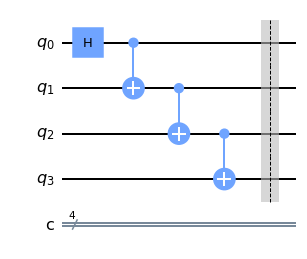

In [20]:
# Setting up the circuits

harp4 = QuantumCircuit(4, 4); stair4 = QuantumCircuit(4, 4);

# Adding H gates

harp4.h(0); stair4.h(0);


# Adding CNOT, ([control1 ,..., controln],[target1 ,..., targetn])

harp4.cx(0,[1,2,3]); stair4.cx([0,1,2],[1,2,3]);

# Add barriers before measurements

harp4.barrier(); stair4.barrier();

stair4.draw(output='mpl') #draw the circuit

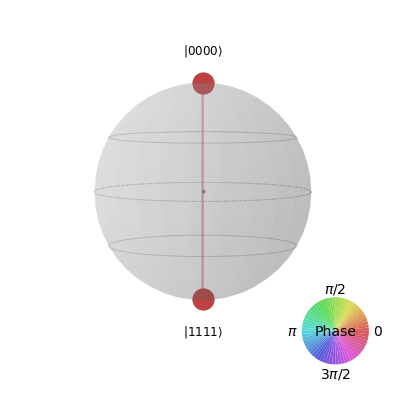

In [21]:
# This part checks if Qiskit is interpreting the cat state correctly by plotting the Bloch Sphere

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

backend = BasicAer.get_backend('statevector_simulator')      # statevector simulator is the backend
result = execute(stair4, backend).result()                   # Run the circuit on the backend
psi  = result.get_statevector(stair4)                        # Declare results as Psi


# Plotting the Bloch sphere
plot_state_qsphere(psi)

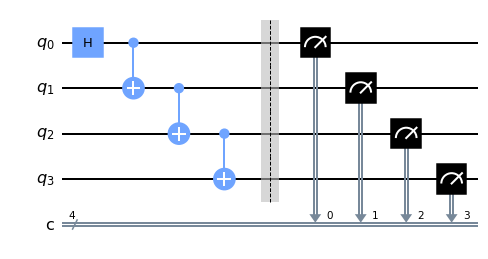

In [22]:
#Adding measurements, you must add measurements after Bloch Sphere

harp4.measure([0,1,2,3], [0,1,2,3]); stair4.measure([0,1,2,3], [0,1,2,3]);

%matplotlib inline
stair4.draw(output='mpl')


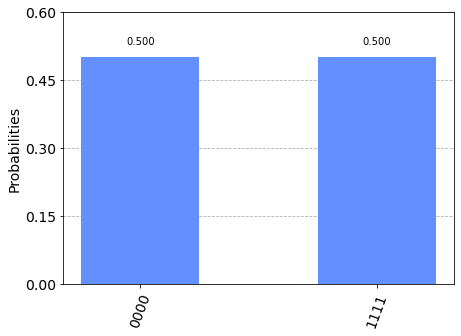

In [23]:
# I always like to run it through the simulator first

simulator = Aer.get_backend('qasm_simulator')
result = execute(stair4, backend = simulator, shots = 8192).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

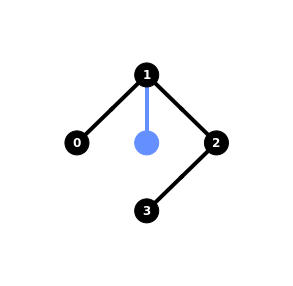

In [24]:
# Transpiler if you would like to declare specific qubits, may not always want to run this
# I skip q2 because, for computers with T shaped geomemtry, it is not connected to q3 
# Depending on the qcomps geometry, additional cnots may be added due to lack of connectivity

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_belem')

stair4 = transpile(stair4, backend, initial_layout=[0, 1, 3, 4])
harp4 = transpile(harp4, backend, initial_layout=[0, 1, 3, 4])

plot_circuit_layout(stair4, backend)

In [25]:
# Making the list of circuits
# This allows you to run a list of circuits per job

qc_lista=[]; qc_listb=[];
for i in range(0,5):
    a=stair4;
    b=harp4;
    qc_lista.append(a);
    qc_listb.append(b);


In [28]:
# Now I run the job on the actual computer, you are allowed to run 5 jobs per computer

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_belem')  

job1 = execute(qc_lista, backend=backend, shots = 8192)
job2 = execute(qc_listb, backend= backend, shots = 8192)


In [29]:
#Monitoring the job, queue status/postion, and when completed
from qiskit.tools.monitor import job_monitor

job_monitor(job1)
job_monitor(job2)

Job Status: job has successfully run
Job Status: job has successfully run


In [38]:
def entropy(p,s): # Defining the function that calculates the Entropy
    if p == 0:
        a = 0
    else:
        a = -p/s*np.log2(p/s)
    return float(a)

In [31]:
#Getting the counts from IBMQ and adding it to a list

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_belem')  

jbs = ['job1 ID','job2 ID']   # You will need to go to IBMQ get your job id, this is just filler


In [52]:
# This section grabs the data and puts it in binary order with zeros
# Qiskit does not print out states with zero counts by default
# For smaller cat states you don't get many zero counts, however with bigger ones you get a lot!

nqbit = 4           # Number of qubits
n = 2**nqbit        # Dimensions of Hilbert Space
vec = np.zeros(n)   # Making a number array of 2^4 zeros

cnts = []

for i in jbs:
    job = backend.retrieve_job(i)  
    result = job.result()
    counts=result.get_counts()

#Grab data from the dict and arranges them in binary order (with zero if the count was zero)
    data =[]
    for i in counts:
        for key,value in i.items():
            idx = 0
            for i,b in enumerate(reversed(key)):
                if b == '1':
                    idx += 2**i
            vec[idx] = value
        data.append(vec)
        vec = np.zeros(n)
    cnts.append(data)

In [68]:
ent = []                           # List of averaged entropy
stdev = []                         # Standard deviation between runs

for job in cnts:
    circ = []                             # This will hold the entropies of each circuit/job
    for run in job:
        dummy=[]                          # This will hold the result of individual counts
        for count in run:
            h = entropy(count,8192)
            dummy.append(h)
        circ.append(np.sum(dummy))
    stdev.append(np.std(circ))
    ent.append(np.average(circ))

In [69]:
print(ent)
print(stdev)

[2.521111765146094, 2.8093755847559114]
[0.013336667805337332, 0.009195675865447278]


In [66]:
#This loop saves the counts as txt files

filenames = ['Stair 4 Belem','Harp 4 Belem']

dir = 'Intended directory of txt file'    # The directory to send the txt file

i = 0                                       # A way to count the file names         

for job in cnts:
    dir1 = dir + filenames[i]
    fp1 = open(dir1,'w')
    for run in job:
        for count in run:
            fp1.write(str(count).ljust(20,' ')+ ', ')
        fp1.write('\n')
    fp1.close()
    i = i + 1
